In [55]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

2.3.0


1.导入训练集与测试集

In [38]:
train_data = pd.read_csv('data/kaggle_house/train.csv')
test_data = pd.read_csv('data/kaggle_house/test.csv')

2.对训练集、测试集的性质考察，包括形状、前几列后几列

In [39]:
train_data.shape

(1460, 81)

In [40]:
test_data.shape

(1459, 80)

In [41]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


3.对数据集进行处理，包括拼接、标准化、独热编码等

In [ ]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
# concat 是将两个表按行拼接在一起，就是垂直拼接

In [ ]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# dtypes 是返回数据类型，不是object的数据类型的索引
all_features[numeric_features]=all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
# lambda 表达式，对整一列进行处理
all_features[numeric_features]= all_features[numeric_features].fillna(0)

In [ ]:
all_features = pd.get_dummies(all_features, dummy_na=True)
# 独热编码，将非数值型的数据转换为数值型的数据，dummy_na=True表示将缺失值也当作合法的特征值并为其创建指示特征
bool_features = all_features.select_dtypes(include=['bool']).columns
# 这里写成all_features = all_features*1也可以直接把bool值转换为数值型
# 这句话和上面的选择逻辑是一样的，只是dataframe是用select_dtypes来选择数据类型,而numpy是用dtype来选择数据类型
all_features[bool_features] = all_features[bool_features].astype('float')
# astype是修改数据类型，也可以*1.0

In [45]:
all_features.dtypes

MSSubClass               float64
LotFrontage              float64
LotArea                  float64
OverallQual              float64
OverallCond              float64
                          ...   
SaleCondition_Alloca     float64
SaleCondition_Family     float64
SaleCondition_Normal     float64
SaleCondition_Partial    float64
SaleCondition_nan        float64
Length: 330, dtype: object

4.将数据集放到tensor中

In [ ]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float64)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float64)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float64).view(-1, 1)
# 这里都用.values是因为pytorch是对应numpy的，但是原来是dataframe，所以要转换
# view(-1,1)是将数据转换为n行1列的数据

5.定义损失函数，初始化网络与参数

In [ ]:
loss = torch.nn.MSELoss()

def get_net(feature_num):
# 写成get_net(feature_num)是为了方便后面的调用，feature_num是输入的特征数
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

In [ ]:
def log_rmse(net,features,labels):
# 定义一个用于评估模型的对数均方根误差（比赛定义的，方便模型之间比较），注意这里只是最后用的，训练中迭代还是普通的均方误差
    with torch.no_grad():
    # no_grad是不进行梯度计算，因为这里只是计算损失，不需要梯度
        clipped_preds = torch.max(net(features),torch.tensor(1.0))
        # 将预测值定义在1以上，防止过小导致出错
        rmse = torch.sqrt(2*loss(clipped_preds.log(),labels.log()).mean())
    return rmse.item()

6.定义训练模型：初始化训练、测试损失，将数据集载入张量，构建训练迭代器，设定优化器，迭代训练

In [ ]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    # 几个参数分别是网络，训练数据，测试数据（可有可无），迭代次数，学习率，权重衰减，批量大小
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate,weight_decay=weight_decay)
    net = net.float()
    #统一数据类型在训练中十分重要
    for epoch in range(num_epochs):
        for X,y in train_iter:
            l = loss(net(X.float()),y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            #标准四步 计算损失，梯度清零，反向传播，更新参数
        train_ls.append(log_rmse(net, train_features, train_labels))
        # 一轮迭代后计算损失
        if test_labels is not None:
        # 如果有测试数据，也计算测试数据的损失
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

7.k折检验，评估模型性能

In [ ]:
def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉验证时所需要的训练和验证数据
    assert k > 1
    fold_size = X.shape[0] // k
    # 划分一折的大小，整除，X的形状是（行，列）
    X_train, y_train = None, None
    # 一开始先初始化为空
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        # 对数据进行切片，每次取一折的数据
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
        # 如果是第k折就是验证数据
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
        # 如果是第一折就是训练数据
            X_train, y_train = X_part, y_part
        else:
        # 如果不是第一折就是训练数据，就要拼接。torch.cat是拼接函数，和dataframe的concat是一样的，dim=0是按行拼接
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

In [ ]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        # 进行第K折检验
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        # data是一个元组，*data是将元组拆包成多个参数
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        # 我们通常只关注最后一折的性能，已经充分训练
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
            # 画图传递的参数是x轴的范围，y轴的训练数据，x轴的标签，y轴的标签，y轴范围，y轴的验证数据，图例
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k
    # 最后算个看k折平均

fold 0, train rmse 0.520301, valid rmse 0.290224
fold 1, train rmse 0.336577, valid rmse 0.330326
fold 2, train rmse 0.337038, valid rmse 0.320143
fold 3, train rmse 0.314985, valid rmse 0.542111
fold 4, train rmse 0.323022, valid rmse 0.386551
fold 5, train rmse 0.336570, valid rmse 0.297888
fold 6, train rmse 0.350808, valid rmse 0.283223
fold 7, train rmse 0.343735, valid rmse 0.273443
fold 8, train rmse 0.334500, valid rmse 0.363835
fold 9, train rmse 0.349460, valid rmse 0.290944
10-fold validation: avg train rmse 0.354700, avg valid rmse 0.337869


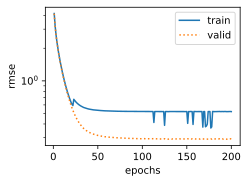

In [ ]:
k, num_epochs, lr, weight_decay, batch_size = 10, 200, 10, 10, 64
train_features = train_features.float()
train_labels = train_labels.float()
# 这里要转换数据类型，因为之前是double类型，但是在训练中是float类型
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

8.训练并预测

In [ ]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    # 用全部的训练数据训练模型，和之前的k折交叉验证不同
    train_ls,_ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    # 训练数据的损失，不需要测试数据的损失
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    # 同样只关心最后一轮的损失
    preds = net(test_features).detach().numpy()
    # detach是将数据从计算图中分离，不进行梯度计算，numpy将数据转换为numpy格式
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    # 转成行向量赋值，如果是列向量会导致数据错位
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    # axis=1是按列拼接
    submission.to_csv('data/submission.csv', index=False)

train rmse 0.336006


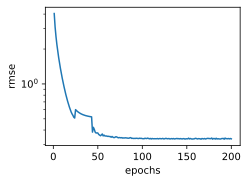

In [54]:
train_features = train_features.float()
test_features = test_features.float()
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)